- EDA To Prediction(DieTanic)와 비교해 볼 것!
https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [112]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [113]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [114]:
# 타이타닉 튜토리얼1에서 다뤘던 데이터 가져오기
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

# 3. Feature engineering
- 본격적인 feature engineering 을 시작해보겠습니다.
- 가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
- 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
- null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.
- Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

# 3.1 Fill Null
## 3.1.1 Fill Null in Age using title

In [115]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [116]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
dtype: int64

In [117]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
FamilySize       0
dtype: int64

- ↑Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + period를 사용해 보겠습니다.
- ↓영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.  
ex) Heikkinen, Miss. Laina  
- pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다

- As we had seen earlier, the Age feature has 177 null values. To replace these NaN values, we can assign them the mean age of the dataset.

- But the problem is, there were many people with many different ages. We just cant assign a 4 year kid with the mean age that is 29 years. Is there any way to find out what age-band does the passenger lie??

- Bingo!!!!, we can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.

## Regex( [A-Za-z]+).
- Okay so here we are using the Regex: ([A-Za-z]+).. 
- It looks for strings which lie between A-Z or a-z and followed by a .(dot). So we successfully extract the Initials from the Name.

In [118]:
#Let's extract the Salutations
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') 
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [119]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr


- pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다

In [120]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- ↓There is 17 titles in the dataset, most of them are very rare and we can group them in 5 categories 

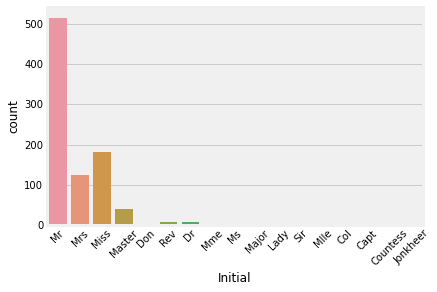

In [121]:
g = sns.countplot(x="Initial",data=df_train)
g = plt.setp(g.get_xticklabels(), rotation=45) 

### replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.
Okay so there are some misspelled Initials like Mlle or Mme that stand for Miss. I will replace them with Miss and same thing for other values

In [122]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [123]:
df_train.groupby('Initial')['Survived'].mean()

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

- 여성과 관계있는 Miss, Mr, Mrs 가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

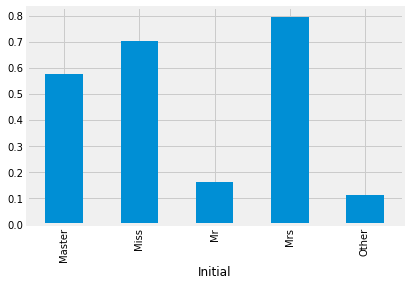

In [124]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. 
- statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 
- 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics 는 train data 의 것을 의미합니다. 
- 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [125]:
df_train.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

#### Age 결측값 채우기 방법1) Age의 평균 이용

- Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.
- pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
- loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [126]:
## Assigning the NaN Values with the Ceil values of the mean ages
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [127]:
df_train.Age.isnull().any() #So no null values left finally 
df_test.Age.isnull().any() #So no null values left finally 

False

- ↑여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보세요!
- 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

#### Age 결측값 채우기 방법2) Looking at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

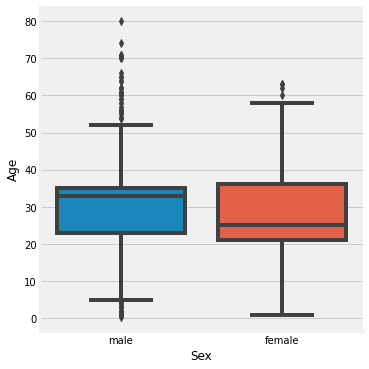

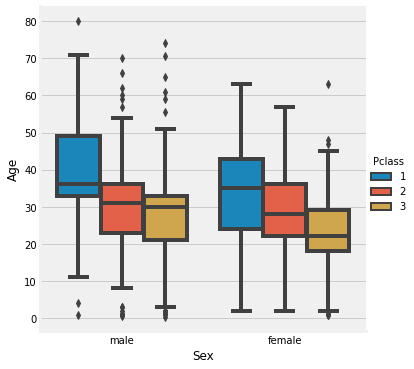

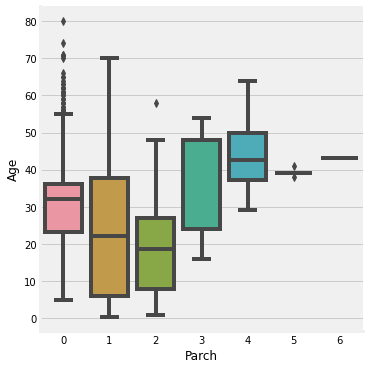

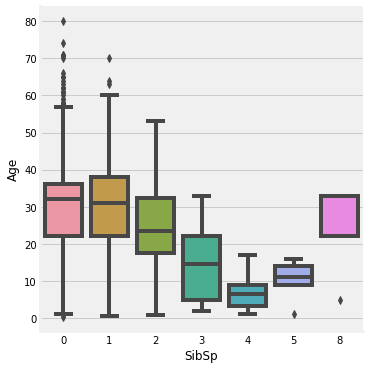

In [128]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=df_train,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=df_train,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=df_train,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=df_train,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is

## 3.1.2 Fill Null in Embarked

In [129]:
# Embarked Null value만 찾고 싶을 때는, sum(df_train['Embarked'].isnull())
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null valuse')



Embarked has 2 Null valuse


In [130]:
# print('Embarked has', df_train.isnull().sum(), 'Null valuse')  는 전체 결측치를 확인할 때. 

- Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
- dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [131]:
df_train['Embarked'].fillna('S', inplace=True)

# 3.2 Change Age(continuous to categorical)
- Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.
- 방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.
- 첫번째로 loc 를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
- 나이는 10살 간격으로 나누겠습니다.

In [132]:
#loc 방법
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [133]:
# 간단한 함수를 만들어 apply 메소드에 넣어주는 방법
# 훨씬 수월

def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
    
df_train['Age_cat_2']= df_train['Age'].apply(category_age)

    

- 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [134]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', 
      (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


- 보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.
- 이제  Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [135]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

# 3.3 Change Initial, Embarked and Sex (string to numerical)
- 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
- map method 를 가지고 간단히 할 수 있습니다.
- 사전 순서대로 정리하여 mapping 하겠습니다

In [136]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

- ↓Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [137]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

- ↓Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [138]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 이제 모든 feature들을 다 수치화를 했습니다.
- 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다.
- -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다.
- 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며,  
dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

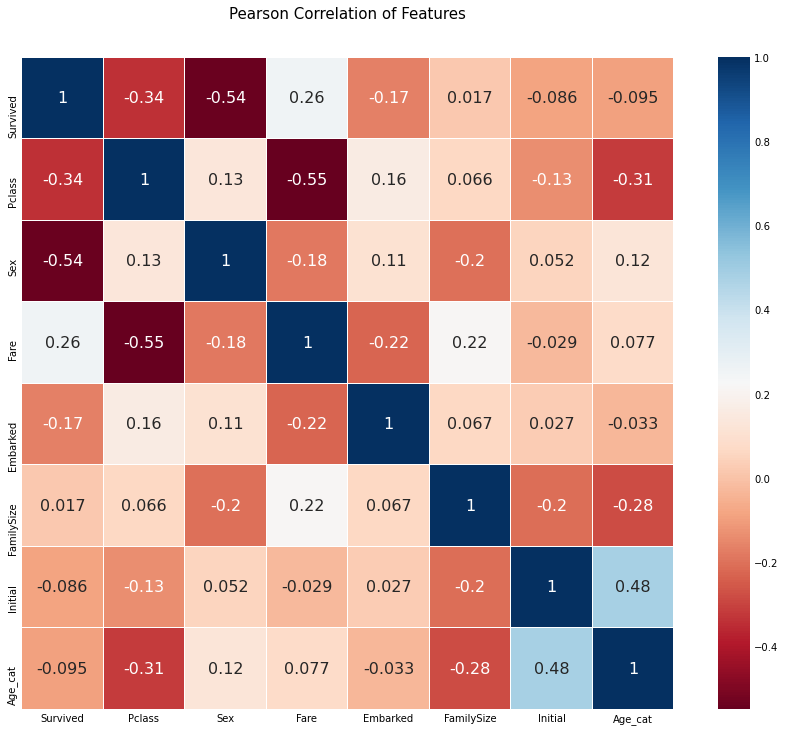

In [139]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
- 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
- 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다.
- 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
- 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다. 거의 다 와갑니다 힙냅시다!

# 3.4 One-hot encoding on Initial and Embarked
- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.
- One-hot encoding 은 위 카테고리를 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.
- pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.
- 현재 5개 카테고리가 있으니, get_dummies를 하면, 자동으로 one-hot encoding이 되어 새로운 컬럼5개가 생깁니다.

In [140]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [141]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,7.2500,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,71.2833,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,53.1000,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,8.0500,NaN,2,1,3,0,0,1,0,0


In [142]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 아주 쉽게 one-hot encoding 을 적용했습니다.

# 3.5 Drop columns
- 고생하셨습니다.
- 필요한 columns 만 남기고 다 지웁시다.

In [143]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [144]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,7.2500,2,2,0,0,1,0,0,0,0,1
1,1,1,0,71.2833,2,3,0,0,0,1,0,1,0,0
2,1,3,0,7.9250,1,2,0,1,0,0,0,0,0,1
3,1,1,0,53.1000,2,3,0,0,0,1,0,0,0,1
4,0,3,1,8.0500,1,3,0,0,1,0,0,0,0,1


In [145]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0.0,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,Embarked_0,Embarked_1,Embarked_2
0,3,1,7.8292,1,3,0,0,1,0,0,0,1,0
1,3,0,7.0000,2,4,0,0,0,1,0,0,0,1
2,2,1,9.6875,1,6,0,0,1,0,0,0,1,0
3,3,1,8.6625,1,2,0,0,1,0,0,0,0,1
4,3,0,12.2875,3,2,0,0,0,1,0,0,0,1


# 4 Building machine learning model and prediction using the trained model
- 이제 준비가 다 되었으니 sklearn 을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [146]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

- 지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.

# 4.1 Preparation - Split dataset into train, valid, test set
- 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.

In [147]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
- 마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
- train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [149]:
#데이터 쪼개기, Train -> (Train, Valid)¶
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)




# 쪼개어진 Train, Valid 데이터의 비율은 (7:3), 내부 난수 값 42, 데이터를 쪼갤 때 섞으며 label 값으로 Stratify 하는 코드 입니다. random_state를 주석 처리하고 데이터를 확인해보시면 계속 바뀝니다.
# x_train, x_valid, y_train, y_valid = train_test_split(data, label, 
#                                                       test_size=0.3,
#                                                       random_state=42,
#                                                       shuffle=True,
#                                                       stratify=label)

# 4.2 Model generation and prediction

In [150]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [151]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.84% 정확도로 생존을 맞춤


# 4.3 Feature importance 
- 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.

- 학습된 모델은 기본적으로 feature importances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
- pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

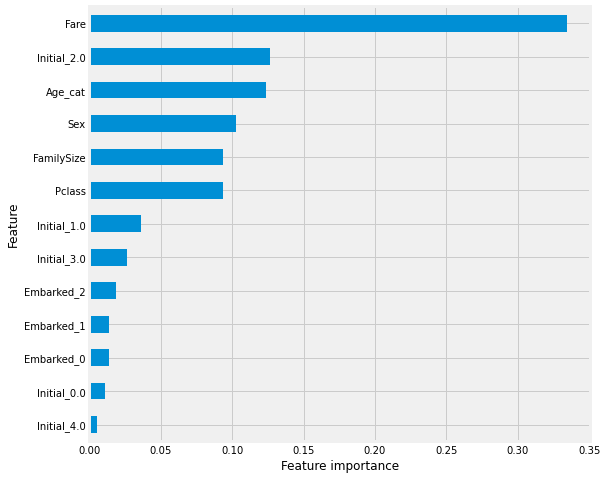

In [152]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다
- 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.
- 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
- featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

# 4.4 Prediction on Test set 
- 이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.

In [158]:
model = RandomForestClassifier()
model.fit(X_train, target_label)
prediction = model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [153]:
submission = pd.read_csv('../input/gender_submission.csv')
submission.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/gender_submission.csv'

In [ ]:
prediction = model.predict(X_test)
submission['Survived'] = prediction
submission.to_csv('./my_first_submission.csv', index=False)